In [ ]:
#importing some useful libarary to play
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


# Downloading DataSet From Kaggle

We are downloading this Dataset from kaggle do checkout for more information about dataset and model trained by owner


https://www.kaggle.com/datasets/splcher/animefacedataset


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

100%|██████████| 395M/395M [00:06<00:00, 65.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


## Setting Factors to refine the data
 Now the data has been downloaded we need to set various factor for Data Training for this we are going to create several variable that can be useful while training data.

In [ ]:
image_size = 64
batch_size = 128
nc = 3  # Number of color channels (RGB)
nz = 100  # Size of the latent vector (input noise to the generator)
ngf = 64  # Size of feature maps in the generator
ndf = 64  # Size of feature maps in the discriminator
num_epochs = 50
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Transformation

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Assuming you have the dataset in 'data/anime'
dataset = dsets.ImageFolder(root='/root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



# Discriminator
*Discriminator is a neural network that distinguishes between real and generated (fake) data. Its primary job is to determine whether a given input (e.g., an image) is from the real dataset or produced by the Generator.*


* The Discriminator takes in images (or other data types) as input.
It outputs a probability score, usually between 0 and 1, indicating how likely it believes the input is real .


* The Discriminator is trained to maximize its ability to correctly classify real and fake data.
It receives feedback from its predictions and adjusts its weights accordingly to improve its classification accuracy.
The Discriminator's loss function is typically a binary cross-entropy loss, measuring how well it can differentiate between real and generated images.








In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Generator
The Generator is a neural network that takes a random input (usually a noise vector) and transforms it into data that mimics the characteristics of real data (like images, audio, or text).

* The Generator starts with a random noise vector (a sequence of random numbers) and tries to create realistic data samples from it.
In the case of image generation, the Generator might output an image that has the same dimensions and characteristics as the images in the real dataset.

* The Generator is trained to produce outputs that can "fool" the Discriminator into classifying them as real.
The Generator’s loss is calculated based on how well it succeeds in tricking the Discriminator. If the Discriminator classifies a generated sample as real, the Generator’s loss decreases, which indicates successful generation.
Over time, the Generator learns to create increasingly realistic data samples by receiving feedback from the Discriminator.

### *The Generator improves through a competitive process with the Discriminator. As the Discriminator becomes better at detecting fakes, the Generator has to improve its outputs to avoid being detected.*

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Weight initialization
Proper initialization of weights can prevent issues like vanishing/exploding gradients and help models converge faster .
Weight initialization is especially important due to the network's depth and the adversarial nature of training.

 ## Weight Initialization Techniques

 m is a layer or module of the neural network.
m.__class__.__name__ retrieves the class name of m (e.g., 'Conv2d' or 'BatchNorm2d').



```
if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)

```
This line checks if the layer is a convolutional layer (like Conv2d or ConvTranspose2d), which will have 'Conv' in its class name.

If it’s a convolutional layer, the weights are initialized using a normal distribution with:

Mean (μ) = 0.0
Standard deviation (σ) = 0.02
This initialization can be expressed mathematically as:

𝑤
∼
𝑁
(
0
,
0.0
2
2
)
w∼N(0,0.02
2
 )
where
𝑁
N is the normal distribution, and
𝑤
w represents the weights of the convolutional layer. This helps the network avoid the vanishing/exploding gradient problem by keeping the initial weights relatively small but non-zero.


```
elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

```
This line checks if the layer is a batch normalization layer (like BatchNorm2d), which will have 'BatchNorm' in its class name.
For batch normalization layers:
Weights are initialized using a normal distribution with:

Mean (μ) = 1.0
Standard deviation (σ) = 0.02
Mathematically:

𝑤
∼
𝑁
(
1.0
,
0.0
2
2
)
w∼N(1.0,0.02
2
 )
Biases are initialized to a constant value of 0:

𝑏
=
0
b=0



In [ ]:
netG = Generator().to(device)  # Create the generator
netD = Discriminator().to(device)  # Create the discriminator

# Initialize weights
def weights_init(m):  # Function to initialize weights
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Binary Cross Entropy
nn.BCELoss() is a loss function in PyTorch called Binary Cross Entropy Loss

Check more here - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


## Training Model

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}] Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")


[0/50] Loss_D: 1.8833, Loss_G: 3.1762, D(x): 0.3724, D(G(z)): 0.4486 / 0.0609
[0/50] Loss_D: 0.4850, Loss_G: 5.3100, D(x): 0.8040, D(G(z)): 0.0685 / 0.0102
[0/50] Loss_D: 1.0221, Loss_G: 14.3902, D(x): 0.6699, D(G(z)): 0.0002 / 0.0000
[0/50] Loss_D: 0.3936, Loss_G: 5.0373, D(x): 0.9311, D(G(z)): 0.2236 / 0.0154
[0/50] Loss_D: 0.3856, Loss_G: 4.7577, D(x): 0.8974, D(G(z)): 0.1921 / 0.0194
[1/50] Loss_D: 0.5166, Loss_G: 6.6720, D(x): 0.9240, D(G(z)): 0.3071 / 0.0026
[1/50] Loss_D: 0.8452, Loss_G: 3.6266, D(x): 0.6126, D(G(z)): 0.0345 / 0.0469
[1/50] Loss_D: 0.5137, Loss_G: 5.2399, D(x): 0.8456, D(G(z)): 0.2354 / 0.0084
[1/50] Loss_D: 0.7339, Loss_G: 5.2660, D(x): 0.8450, D(G(z)): 0.3472 / 0.0096
[1/50] Loss_D: 0.5684, Loss_G: 4.3187, D(x): 0.7106, D(G(z)): 0.1221 / 0.0222
[2/50] Loss_D: 0.3891, Loss_G: 3.4436, D(x): 0.8901, D(G(z)): 0.2138 / 0.0489
[2/50] Loss_D: 0.4065, Loss_G: 4.7816, D(x): 0.8856, D(G(z)): 0.2145 / 0.0124
[2/50] Loss_D: 0.5253, Loss_G: 5.7493, D(x): 0.8235, D(G(z)): 0

## Save the Model for Future

In [ ]:
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

# Run Model

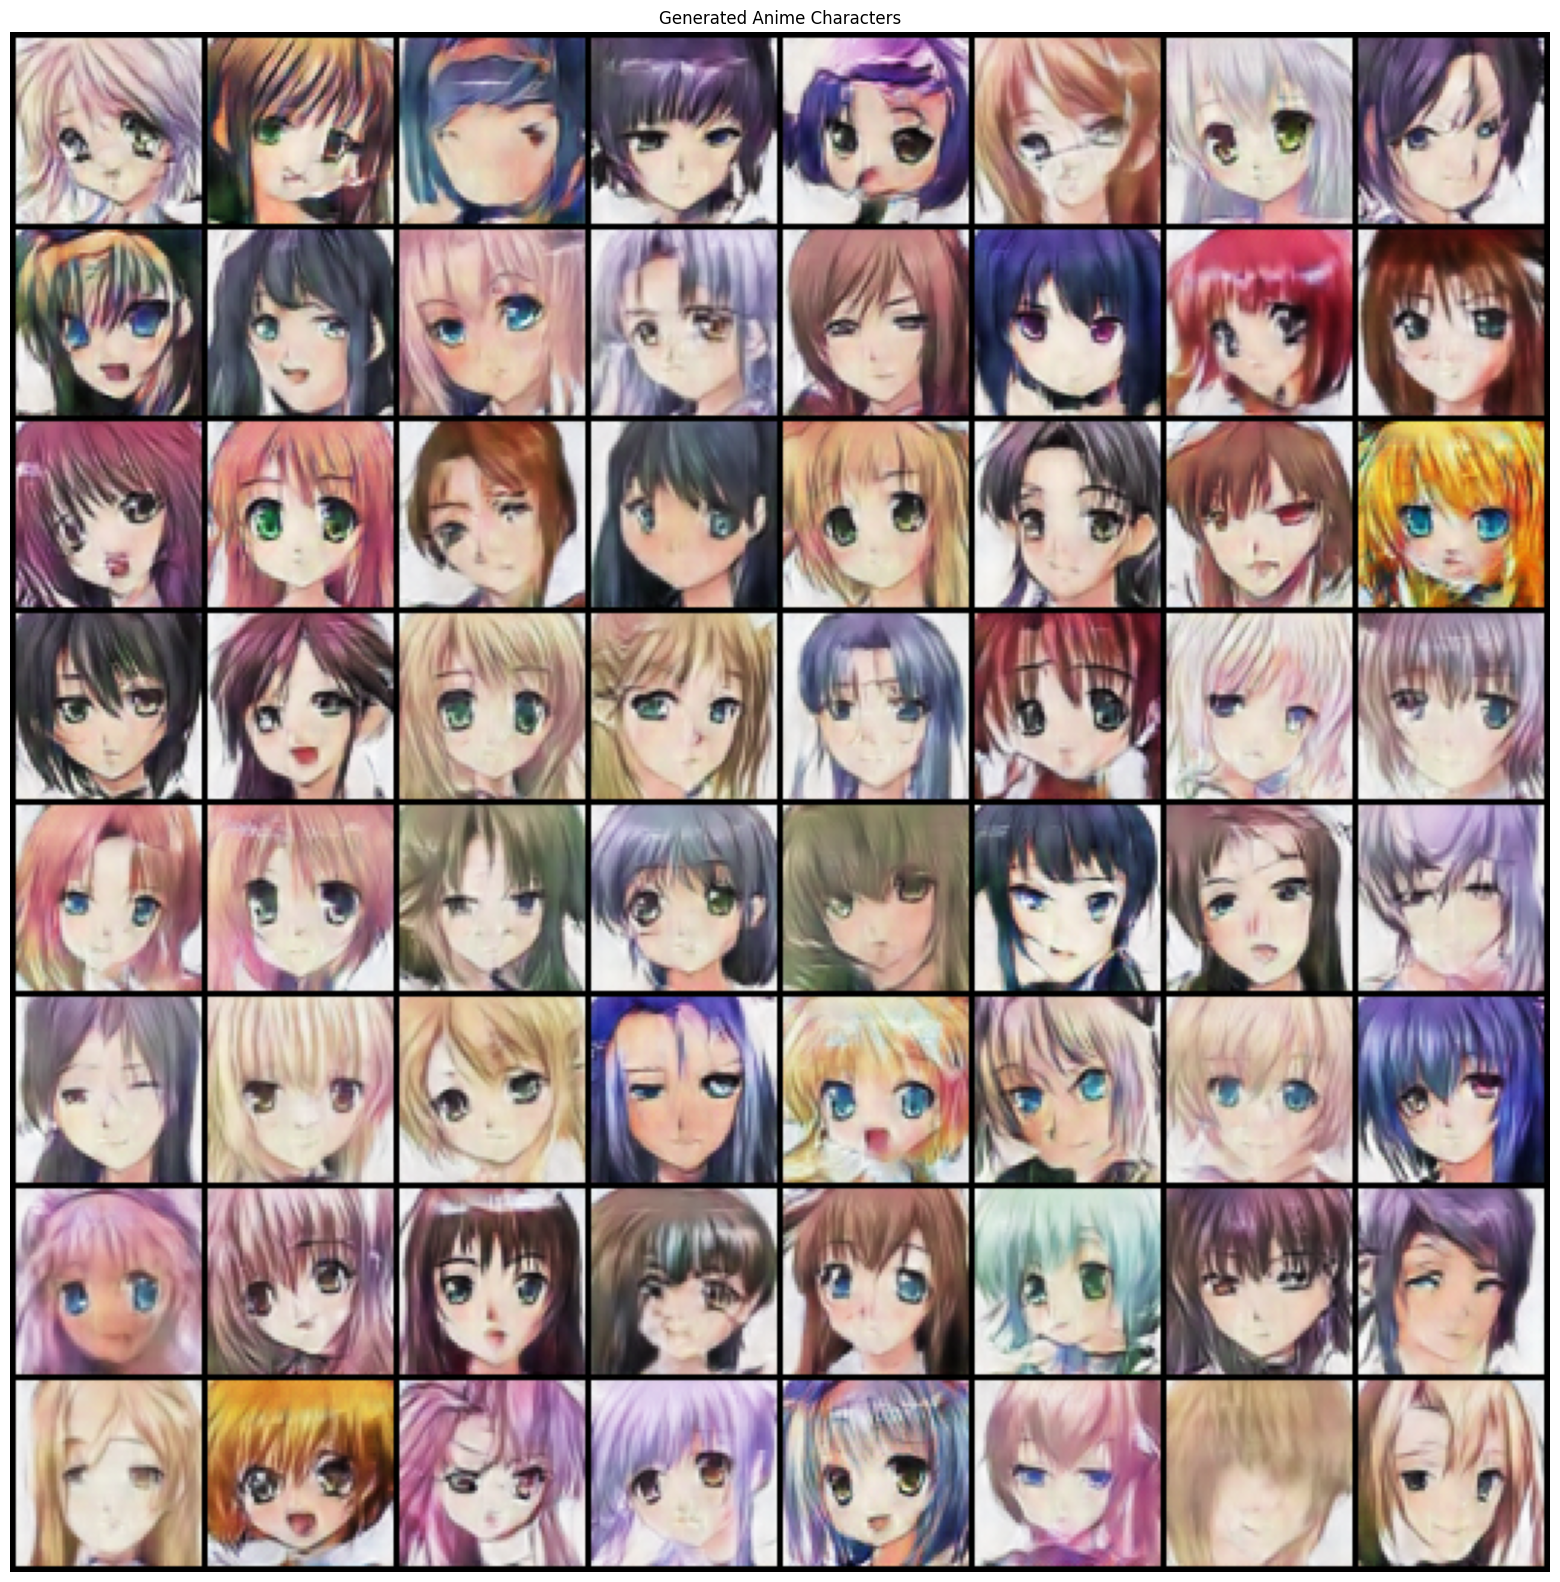

In [ ]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Generated Anime Characters")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.show()


### Providing more data enhances the model's performance, helping it learn complex patterns more effectively and improve accuracy over time.